<a href="https://colab.research.google.com/github/Pehlevan-Group/sgd_structured_features/blob/main/unstructured_iso_scalings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys


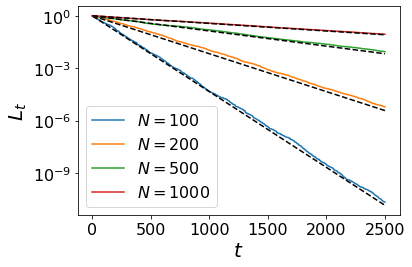

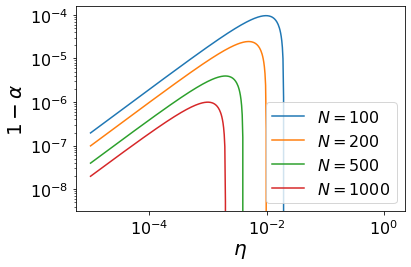

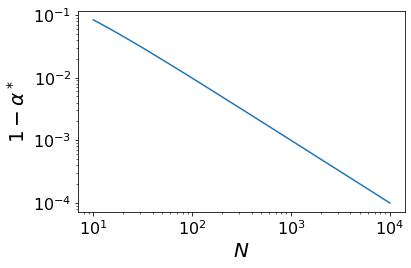

 loss: 0.0510762

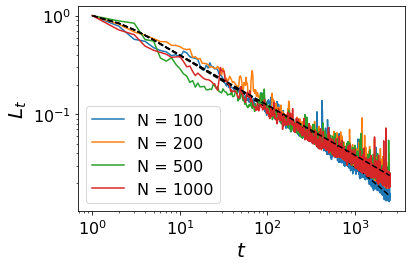

In [ ]:

def iso_sgd(N, T):

    w_star = 1/np.sqrt(N) * np.ones(N)
    eta = 1/(N+2)
    w = np.zeros(N)
    losses = np.zeros(T)
    for t in range(T):
        psi = np.random.standard_normal(N)
        w += - eta * psi * np.dot(psi, w-w_star)
        losses[t] = np.dot(w-w_star, w-w_star)
    return losses


fontsize = 16
plt.rcParams.update({'font.size': fontsize})
myaxis_font=20



T = 2500
Nvals = [100,200,500,1000]
all_losses = []
for i,N in enumerate(Nvals):
    losses = iso_sgd(N,T)
    all_losses += [losses]

plt.figure(figsize=(6,4))

for i,N in enumerate(Nvals):
    plt.semilogy(np.linspace(1,T,T), all_losses[i],label = r'$N = %d$' % N)
    plt.semilogy(np.linspace(1,T,T),np.exp( - np.linspace(1,T,T)/N ), '--',color = 'black')
plt.legend()
plt.xlabel(r'$t$',fontsize=myaxis_font)
plt.ylabel(r'$L_t$',fontsize=myaxis_font)
#plt.title(r'White Code',fontsize=myaxis_font)
plt.tight_layout()
plt.savefig('isotropic_vary_N.pdf')
plt.show()

eta_vals = np.logspace(-5, 1e-1, 500)
#plt.figure(figsize=(2.4,2))

for i,N in enumerate(Nvals):
    p_eta = 2*eta_vals/(N+2) - eta_vals**2
    plt.loglog(eta_vals,p_eta, label = r'$N = %d$' % N)
#plt.loglog(eta_vals, eta_vals, '--', color = 'black')
plt.xlabel(r'$\eta$',fontsize=myaxis_font)
plt.ylabel(r'$1-\alpha$',fontsize=myaxis_font)
#plt.title(r'White Learning Rate',fontsize=myaxis_font)
plt.legend()
plt.tight_layout()
plt.savefig('isotropic_effective_learning_rate.pdf')
plt.show()

N_vals = np.logspace(1,4,100)
opt = 1/(N_vals +2)
#plt.figure(figsize=(2.4,2))
plt.loglog(N_vals, opt)
plt.xlabel(r'$N$', fontsize=myaxis_font)
plt.ylabel(r'$1-\alpha^*$',fontsize=myaxis_font)
#plt.title(r'Optimal $\alpha$ White Code', fontsize=myaxis_font)
plt.tight_layout()
plt.savefig('isotropic_optimal_eta.pdf')
plt.show()



def true_theory(spectrum, v, eta, T):
    losses = np.zeros(T)
    A = np.eye(len(spectrum)) - 2*eta*np.diag(spectrum) + 2*eta**2 *np.diag(spectrum**2) + eta**2*np.outer(spectrum,spectrum)
    mode_decay = spectrum
    for t in range(T):
        mode_decay= A @ mode_decay
        losses[t] = np.dot(v*spectrum, mode_decay)
    #plt.loglog(losses)
    #plt.show()
    return losses

def sgd_expt(spectrum, teacher_spectrum, noise_spectrum, eta, T, num_avg):
    N = len(spectrum)
    w_star = teacher_spectrum**(0.5)
    losses = np.zeros((T, num_avg))
    for i in range(num_avg):
        w = np.zeros(N)
        all_psi =  np.random.standard_normal((T,N)) @ np.diag(np.sqrt(spectrum))
        all_noise =  np.random.standard_normal((T,N)) @ np.diag(np.sqrt(noise_spectrum))
        #all_psi = np.random.multivariate_normal(np.zeros(N), np.diag(spectrum), T)
        #all_noise = np.random.multivariate_normal(np.zeros(N), np.diag(noise_spectrum), T)
        for t in range(T):
            psi = all_psi[t,:]
            eps = all_noise[t,:]
            w += - eta * (psi+eps) * np.dot(psi+eps,w-w_star)
            #loss = np.dot(w-w_star, spectrum*(w-w_star))
            loss = np.dot(w-w_star, (spectrum+noise_spectrum)*(w-w_star)) + np.dot(w_star, noise_spectrum*w_star)
            losses[t, i] = loss
            sys.stdout.write('\r loss: %.7f' % loss)
    return np.mean(losses, axis =1 ), np.std(losses, axis=1)

b = 2
a = 2
eta = 0.3
plt.figure(figsize=(6,4))

for i,N in enumerate(Nvals):
    spectrum = np.linspace(1,N,N)**(-b)

    #losses_expt = all_losses[i]
    #pred_i2 = all_pred[i]
    #scaled_expt = losses_expt /losses_expt[0]
    v = np.linspace(1,N,N)**(-a) / spectrum
    losses_expt, std_expt = sgd_expt(spectrum, v, np.zeros(len(spectrum)), eta, T, 10)

    losses = np.zeros(T)
    vect = spectrum
    A = np.eye(len(spectrum)) - 2*eta*np.diag(spectrum) + 2*eta**2*np.diag(spectrum**2)+ eta**2 * np.outer(spectrum, spectrum)

    s,V = np.linalg.eigh(A)

    proj_1  = V.T @ spectrum
    proj_2 = V.T  @ (np.linspace(1,len(spectrum),len(spectrum))**(-a) / spectrum)
    loss_full = []
    s_t = s
    for t in range(T):
        d = np.diag(s_t)
        s_t = s*s_t
        loss_full += [ np.dot(proj_1, np.dot(d,proj_2)) ]

    #tv_tail = np.log10( [tvi for tvi in tv if tvi > 1000 and tvi < T] )
    #tail_loss = tv_tail**(-1+1/b)
    tv = np.linspace(1,T,T)
    plt.loglog(tv,losses_expt/losses_expt[0], label = 'N = %d' % N, color = 'C%d' % i)
    plt.loglog(tv,loss_full /loss_full[0], '--', color = 'black')
    #beta = min(a-1,2*b-1)/b
    #approx = tv_theory**(-beta)
    #plt.loglog(tv_theory, approx / approx[-1] * scaled_expt[-1], '--', color = 'black')

plt.legend()
plt.xlabel(r'$t$', fontsize=myaxis_font)
plt.ylabel(r'$L_t$', fontsize=myaxis_font)
#plt.title(r'Power Law Finite $\eta$', fontsize=myaxis_font)
plt.tight_layout()
plt.savefig('power_law_vary_N.pdf')
plt.show()
